In [1]:
import pandas as pd
import seaborn as sns

from s2_analytics import sqlite_import

con, cur = sqlite_import.import_games("logs_ranked/", "/tmp/s2_ranked.sql", period_days=60)

## Summary

In [2]:
query = """
select
    datetime(min(id)/1000, 'unixepoch') first_game_start_time,
    datetime(max(id)/1000, 'unixepoch') last_game_start_time,
    count(1) games_count
from game
"""
pd.read_sql_query(query, con)

,first_game_start_time,last_game_start_time,games_count
0,2022-11-17 20:24:26,2023-01-16 20:05:59,698


## Maps played

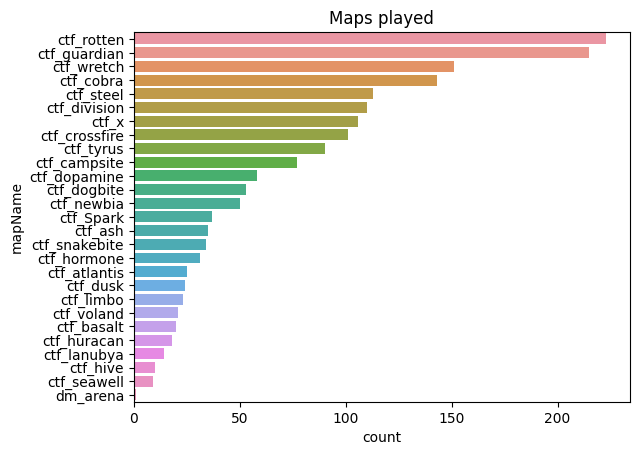

In [3]:
result6 = pd.read_sql_query("select mapName, count(1) as count from round group by mapName order by count desc", con)
sns.barplot(result6, y="mapName", x="count").set(title="Maps played")
pass

In [4]:
result6

,mapName,count
0,ctf_rotten,223
1,ctf_guardian,215
2,ctf_wretch,151
3,ctf_cobra,143
4,ctf_steel,113
5,ctf_division,110
6,ctf_x,106
7,ctf_crossfire,101
8,ctf_tyrus,90
9,ctf_campsite,77


## Average cap count per round

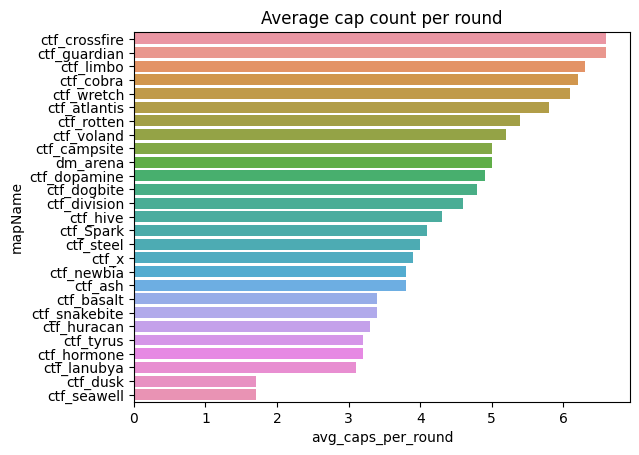

In [5]:
query = """
select distinct mapName,
round(1.0 *
    (select count(1) from event_cap c where r.mapName = c.mapName)/
    (select count(1) from round rr where r.mapName = rr.mapName), 1) avg_caps_per_round
from round r order by avg_caps_per_round desc;
"""
result7 = pd.read_sql_query(query, con)
sns.barplot(result7, y="mapName", x="avg_caps_per_round").set(title="Average cap count per round")
pass

In [6]:
result7

,mapName,avg_caps_per_round
0,ctf_crossfire,6.6
1,ctf_guardian,6.6
2,ctf_limbo,6.3
3,ctf_cobra,6.2
4,ctf_wretch,6.1
5,ctf_atlantis,5.8
6,ctf_rotten,5.4
7,ctf_voland,5.2
8,ctf_campsite,5.0
9,dm_arena,5.0


In [7]:
## Average rounds per game

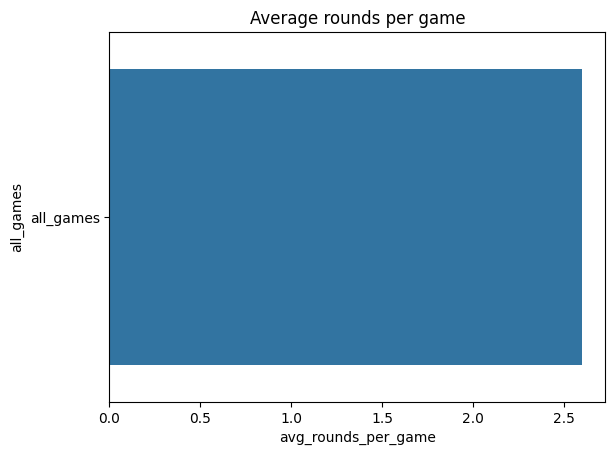

In [8]:
query = """select
"all_games" as all_games,
(select count(distinct game) from round) games_played,
(select count(1) from round) rounds_played,
round(1.0*(select count(1) from round)/(select count(distinct game) from round),1) avg_rounds_per_game
"""
result_rounds_per_game = pd.read_sql_query(query, con)
sns.barplot(result_rounds_per_game, y="all_games", x="avg_rounds_per_game").set(title="Average rounds per game")
pass

In [9]:
result_rounds_per_game

,all_games,games_played,rounds_played,avg_rounds_per_game
0,all_games,696,1792,2.6


## Round result

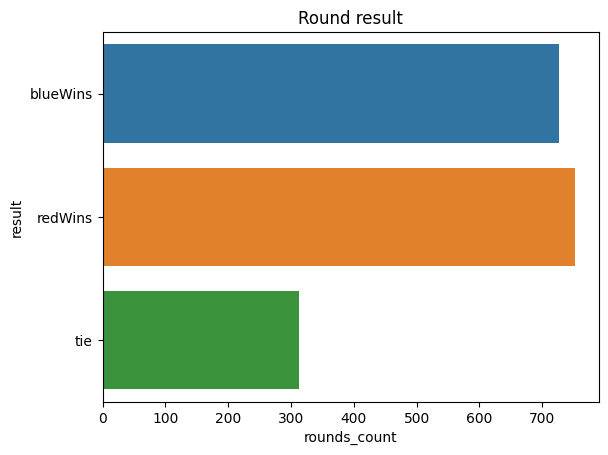

In [10]:
query = """
select result, count(1) rounds_count from round group by result;
"""
result_round_result = pd.read_sql_query(query, con)
sns.barplot(result_round_result, y="result", x="rounds_count", orient="h").set(title="Round result")
pass

## Rounds finished before time limit

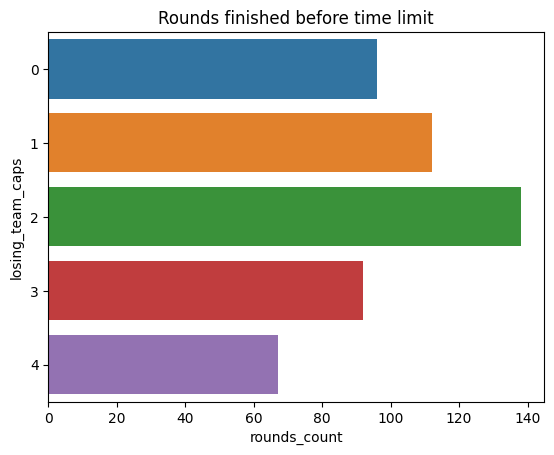

In [11]:
query = """
select
5 - abs(blueCaps - redCaps) losing_team_caps,
count(1) as rounds_count,
round(315 - (1.0*endTime - startTime)/1000,1) seconds_left_avg
from round where blueCaps = 5 or redCaps = 5 group by losing_team_caps;
"""
result_finished_before_limit = pd.read_sql_query(query, con)
sns.barplot(result_finished_before_limit, y="losing_team_caps", x="rounds_count", orient="h").set(title="Rounds finished before time limit")
pass

In [12]:
result_finished_before_limit

,losing_team_caps,rounds_count,seconds_left_avg
0,0,96,70.4
1,1,112,54.7
2,2,138,104.5
3,3,92,13.5
4,4,67,105.9


## Weapons

### Kills per weapon

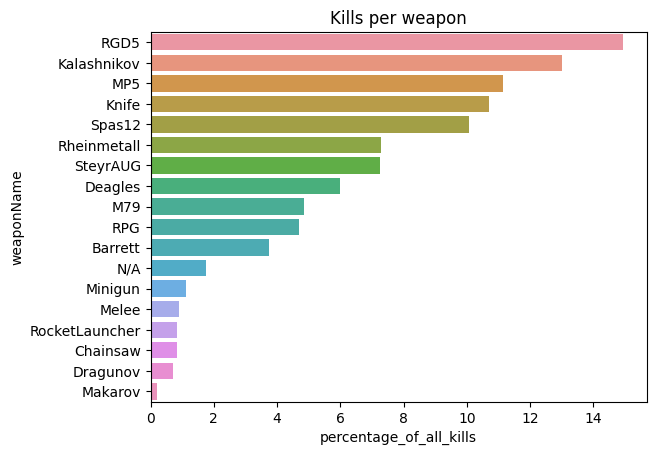

In [13]:
result8 = pd.read_sql_query(
    "select weaponName, round(100.0*count(1)/(select count(1) from event_kill ek),2) as percentage_of_all_kills from event_kill group by weaponName order by percentage_of_all_kills desc", con)
sns.barplot(result8,
            y="weaponName", x="percentage_of_all_kills").set(title="Kills per weapon")
pass

In [14]:
result8

,weaponName,percentage_of_all_kills
0,RGD5,14.93
1,Kalashnikov,13.00
2,MP5,11.13
3,Knife,10.69
4,Spas12,10.08
5,Rheinmetall,7.28
6,SteyrAUG,7.26
7,Deagles,5.99
8,M79,4.84
9,RPG,4.70
